# Analyse $\delta$ sweep of network system

Author: Juvid Aryaman


In [1]:
import mitonetworks.det as mtd
import mitonetworks.stoch as mts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

In [2]:
warnings.simplefilter("ignore", UserWarning) # when generating svg's get lots of useless UserWarnings, so suppress them

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
mts.reset_plots()

# Process $\delta$ sweep

In [5]:
param_sw_vals = pd.read_csv('../../Make_sweep_vals/delta_sw_params.csv')
param_sw_vals

,xi,beta,gamma,kappa,b,mu,delta,h_target,ws_init,wf_init,ms_init,mf_init
0,0.0,33.12,0.037851,0.0,0.000012,0.023,-5.00,0.10,639.0,2749.0,71.0,306.0
1,0.0,33.12,0.037851,0.0,0.000012,0.023,-1.00,0.30,497.0,2137.0,213.0,917.0
2,0.0,33.12,0.037851,0.0,0.000012,0.023,-0.10,0.45,367.0,1169.0,299.0,954.0
3,0.0,33.12,0.037851,0.0,0.000012,0.023,-0.01,0.45,357.0,1029.0,292.0,843.0
4,0.0,33.12,0.037851,0.0,0.000012,0.023,0.01,0.45,355.0,1001.0,290.0,818.0
5,0.0,33.12,0.037851,0.0,0.000012,0.023,0.10,0.45,346.0,886.0,283.0,725.0
6,0.0,33.12,0.037851,0.0,0.000012,0.023,1.00,0.30,323.0,362.0,138.0,155.0
7,0.0,33.12,0.037851,0.0,0.000012,0.023,1.50,0.45,203.0,148.0,166.0,121.0
8,0.0,33.12,0.037851,0.0,0.000012,0.023,2.00,0.20,303.0,232.0,76.0,58.0


In [6]:
analysis = mts.AnalyseDataFeedbackControl(dir_df_params="../../Make_sweep_vals/delta_sw_params.csv",dir_data="../Data/",ctrl_name="lfc")

In [7]:
analysis.make_gradients()
analysis.compute_errors()

In [8]:
analysis.errors

,block_idx,grad_vh_sim,grad_vh_ansatz,error_sim_ansatz
0,0,2.083715e-07,2.076065e-07,0.003671
1,1,4.837010e-07,4.842972e-07,0.001233
2,2,9.796380e-07,9.744965e-07,0.005248
3,3,1.158579e-06,1.162707e-06,0.003562
4,4,1.212679e-06,1.209356e-06,0.002740
5,5,1.430362e-06,1.427209e-06,0.002204
6,6,4.673812e-06,4.652234e-06,0.004617
7,7,1.049520e-05,1.032026e-05,0.016669
8,8,6.334464e-06,6.239520e-06,0.014989


In [9]:
e = analysis.errors
error_ansatz_delta = []
successful_delta_sw_blocks = []
worst_block = [-np.infty,-np.infty] # find param with biggest error
for i in range(len(e)):
    param_try = i
    try:    
        err_delta_val = np.log10(e.loc[e["block_idx"]==param_try]['error_sim_ansatz'].values[0])
        error_ansatz_delta.append(err_delta_val)
        successful_delta_sw_blocks.append(param_try)        
    except IndexError:
        continue
    if err_delta_val > worst_block[1]:
            worst_block[0] = param_try
            worst_block[1] = err_delta_val

In [10]:
worst_block

[7, -1.7780829137739063]

In [11]:
param_df = pd.read_csv('../../Make_sweep_vals/delta_sw_params.csv')

In [12]:
delta_vals_try = param_df.iloc[successful_delta_sw_blocks]['delta']
len(delta_vals_try), len(error_ansatz_delta)

(9, 9)

In [13]:
vh = pd.read_pickle('./lfc_vh') # heteroplasmy variance for all parametrizations
worst_vh_profile = vh.loc[vh["block_idx"]==worst_block[0]]
worst_vh_profile.head()

,block_idx,t,vh_sim,vh_ansatz
357,7.0,0.0,0.000000,0.000000
358,7.0,10.0,0.000103,0.000103
359,7.0,20.0,0.000209,0.000206
360,7.0,30.0,0.000311,0.000310
361,7.0,40.0,0.000415,0.000413


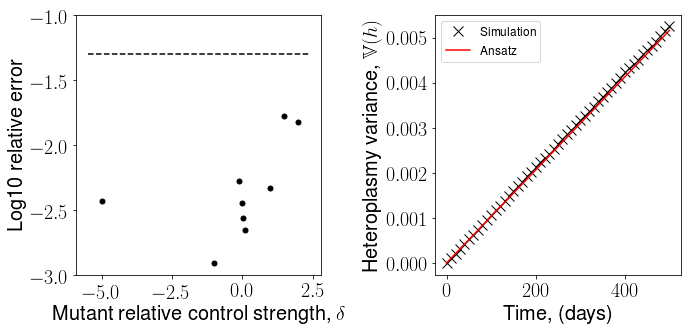

In [15]:
fig, axs = plt.subplots(1,2, figsize=(2*5,5))

ax = axs[0]
ax.plot(delta_vals_try,error_ansatz_delta,'k.',label='Ansatz')
ax.set_xlabel('Mutant relative control strength, $\delta$')
ax.set_ylabel('Log10 relative error')
ax.plot(1.1*np.linspace(min(delta_vals_try),1.1*max(delta_vals_try)),np.log10(0.05)*np.ones(50),'--k')
ax.set_ylim([-3,-1])



ax = axs[1]
ax.plot(worst_vh_profile['t'],worst_vh_profile['vh_sim'],'kx',label='Simulation')
ax.plot(worst_vh_profile['t'],worst_vh_profile['vh_ansatz'],'-r',mfc='none',label='Ansatz')
ax.legend(prop={'size':12})
ax.set_xlabel('Time, (days)')
ax.set_ylabel('Heteroplasmy variance, $\mathbb{V}(h)$')



plt.tight_layout()

plt.savefig('error_delta_sweep.svg')
